# Theme 6 - Plate-scale Geodynamics
OOI Data Labs Education Nuggets

_Written by Lori Garzio, Rutgers University_

_Disclaimer: data used in this example were downloaded on Aug 19, 2019. The file format and/or contents could have changed._

**Objective**: Demonstrate how to download Bottom Pressure and Tilt data from the OOI system using the Machine-to-Machine (M2M) interface and export the data as a .csv file.

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/Users/lgarzio/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## 1. Request Data from OOINet

* **Cabled Axial Seamount** - Central Caldera: Bottom Pressure and Tilt
    * Instrument: RS03CCAL-MJ03F-05-BOTPTA301
    * Time range: 2015-04-10 to 2015-05-15
    * Delivery method: streamed
    * Data stream: botpt_nano_sample
    * Parameter name: bottom_pressure

The **request_data** function below sends data requests with inputs specified by the user to OOINet and returns the THREDDs urls where the downloaded data files can be found.

In [2]:
# enter your OOI API username and token, and directory where output .csv files are saved
API_USERNAME = ''
API_TOKEN = ''
save_dir = '/Users/lgarzio/Documents/OOI/Nuggets/'

In [3]:
def request_data(reference_designator, method, stream, start_date=None, end_date=None):
    site = reference_designator[:8]
    node = reference_designator[9:14]
    instrument = reference_designator[15:]

    # Create the request URL
    api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
    data_request_url = '/'.join((api_base_url, site, node, instrument, method, stream))

    # All of the following are optional, but you should specify a date range
    params = {
        'format': 'application/netcdf',
        'include_provenance': 'true',
        'include_annotations': 'true'
    }
    if start_date:
        params['beginDT'] = start_date
    if end_date:
        params['endDT'] = end_date

    # Make the data request
    r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
    data = r.json()

    # Return just the THREDDS URL
    return data['allURLs'][0]

Now, use that **request_data** function to download data for this instrument. You only need to do this once! These lines are commented out to prevent accidental re-submission of data requests.

In [4]:
# url = request_data('RS03CCAL-MJ03F-05-BOTPTA301', 'streamed', 'botpt_nano_sample',
#                    '2015-04-10T00:00:00.000Z', '2015-05-15T00:00:00.000Z')
# print('url = %s' %url)

## 2. Load Data Files

Copy the links to the THREDDs catalog above that resulted from the **request_data** function (to avoid re-requesting the data). Note: the url must be surrounded by quotations. 

**Note**: this data request may take a while to fulfill because it's a very dense dataset. Later on we will calculate minute-averaged data to make the dataset more manageable.

In [5]:
url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20190819T185047529Z-RS03CCAL-MJ03F-05-BOTPTA301-streamed-botpt_nano_sample/catalog.html'

The **get_data** function below:
* selects the appropriate datasets in a THREDDs catalog by selecting NetCDF files and removing collocated datasets (if provided)
* creates an empty dictionary with placeholders to populate with data just for variables of interest
* creates another dictionary to store the units for the variables of interest
* opens the dataset(s), extracts the data and units for the variables of interest and adds them to the dictionaries
* converts the data dictionary to a dataframe
* returns the dataframe and the dictionary containing the variable units. 

This type of function is most useful when working with multiple large/dense datasets (such as this cabled dataset), but is also fine for working with smaller datasets.

In [6]:
def get_data(url, vars):
    # Function to grab all data from specified directory
    tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
    dataset = requests.get(url).text
    ii = re.findall(r'href=[\'"]?([^\'" >]+)', dataset)
    # x = re.findall(r'(ooi/.*?.nc)', dataset)
    x = [y for y in ii if y.endswith('.nc')]
    for i in x:
        if i.endswith('.nc') == False:
            x.remove(i)
    for i in x:
        try:
            float(i[-4])
        except:
            x.remove(i)
    # dataset = [os.path.join(tds_url, i) for i in x]
    datasets = [os.path.join(tds_url, i.split('=')[-1]) for i in x]

    # remove collocated data files if necessary
    catalog_rms = url.split('/')[-2][20:]
    selected_datasets = []
    for d in datasets:
        if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
            selected_datasets.append(d)

    # create a dictionary to populate with data from the selected datasets
    data_dict = {'time': np.array([], dtype='datetime64[ns]')}
    unit_dict = {}
    for v in vars:
        data_dict.update({v: np.array([])})
        unit_dict.update({v: []})

    for sd in selected_datasets:
        ds = xr.open_dataset(sd, mask_and_scale=False)
        data_dict['time'] = np.append(data_dict['time'], ds['time'].values)
        for var in vars:
            data_dict[var] = np.append(data_dict[var], ds[var].values)
            units = ds[var].units
            if units not in unit_dict[var]:
                unit_dict[var].append(units)

    # convert dictionary to a dataframe
    df = pd.DataFrame(data_dict)

    return df, unit_dict

In [7]:
# Specify the variable(s) of interest and get the data from the datasets - this may take a while
# because this is a very high-resolution dataset
variables = ['bottom_pressure']

data, units = get_data(url, variables)
print(units)

{'bottom_pressure': ['psia']}


In [8]:
# make sure the timestamps are in ascending order
data.sort_values(by=['time'], inplace=True)  

# print the first few lines of the dataframe
data.head()

,time,bottom_pressure
46654513,2015-04-10 00:00:00.000000000,2254.327881
46654514,2015-04-10 00:00:00.050000384,2254.327881
46654515,2015-04-10 00:00:00.099999744,2254.328369
46654516,2015-04-10 00:00:00.150000128,2254.328613
46654517,2015-04-10 00:00:00.200000000,2254.327881


## Quick Data Plots
Make quick plots to make sure you downloaded the correct data. First, we will need to calculate minute averages to make the dataset more manageable.

In [9]:
# rename and add units to the columns
data = data.rename(columns={'bottom_pressure': 'Bottom Pressure ({})'.format(
    units['bottom_pressure'][0])})

# calculate minute averages
df_minute = data.resample('T', on='time').mean().dropna(how='all').reset_index()
df_minute.head()

,time,Bottom Pressure (psia)
0,2015-04-10 00:00:00,2254.326463
1,2015-04-10 00:01:00,2254.326730
2,2015-04-10 00:02:00,2254.326402
3,2015-04-10 00:03:00,2254.328363
4,2015-04-10 00:04:00,2254.328497


Now, plot the minute-averaged data.

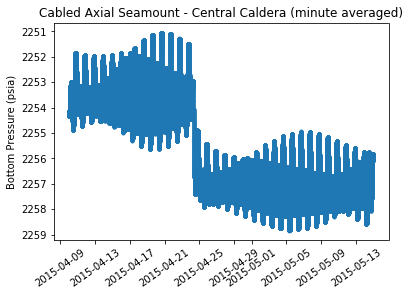

In [10]:
fig, ax = plt.subplots()
plt.plot(df_minute['time'], df_minute['Bottom Pressure (psia)'], '.')
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('Bottom Pressure ({})'.format(units['bottom_pressure'][0]))
ax.set_title('Cabled Axial Seamount - Central Caldera (minute averaged)')
plt.xticks(rotation=35);

Pressure in psia doesn't mean much to most oceanographers, so let's add another column to the dataframe to calculate pressure in dbar. A quick google search tells me that 1 psia = 0.689476 dbar.

In [11]:
df_minute['Bottom Pressure (dbar)'] = df_minute['Bottom Pressure (psia)'] * 0.689476
df_minute.head()

,time,Bottom Pressure (psia),Bottom Pressure (dbar)
0,2015-04-10 00:00:00,2254.326463,1554.303992
1,2015-04-10 00:01:00,2254.326730,1554.304176
2,2015-04-10 00:02:00,2254.326402,1554.303951
3,2015-04-10 00:03:00,2254.328363,1554.305302
4,2015-04-10 00:04:00,2254.328497,1554.305395


Make another plot, this time of the pressure in dbar. You can see the seafloor dropping by several decibars during the eruption on April 24 (in addition to the daily tidal cycle).

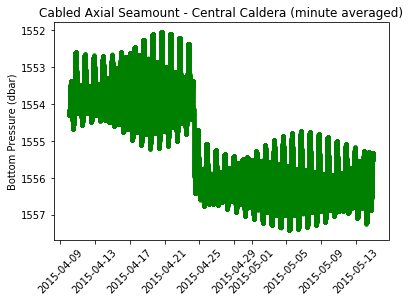

In [12]:
fig, ax = plt.subplots()
plt.plot(df_minute['time'], df_minute['Bottom Pressure (dbar)'], 'g.')
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('Bottom Pressure (dbar)')
ax.set_title('Cabled Axial Seamount - Central Caldera (minute averaged)')
plt.xticks(rotation=45);

## 3. Export to csv
Export the minute-averaged dataset to a .csv file.

In [13]:
df_minute.sort_values(by=['time'], inplace=True)  # make sure the timestamps are in ascending order

df_minute.to_csv(os.path.join(save_dir, 'Theme6_Axial_Seamount_Eruption.csv'), index=False)